<a href="https://colab.research.google.com/github/kimisuke0503/colab-research/blob/main/needs_scan_panel/needs_2d_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

needs_scan_panel/needs_2d_visualization.ipynb

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import sys
import random
import csv
from sklearn.metrics import roc_auc_score

np.set_printoptions(suppress=True)

# データ読み込み

In [11]:
data_training = pd.read_csv('needs_scan_panel_training.csv', header=None)
display(data_training)
data_test = pd.read_csv('needs_scan_panel_test.csv', header=None)
X_needs = data_training.values
test_needs = data_test.values
print(X_needs)
print(test_needs)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1,0,1,1,1,1,0,0,1,1,1,0,1,0,0,1,1,0
1,1,0,0,1,1,0,1,0,1,1,1,0,1,0,1,1,0,1
2,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0
3,1,0,1,0,0,0,1,1,0,1,1,0,1,1,1,1,0,0
4,1,1,1,1,1,0,1,1,0,1,1,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,1,0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1
992,0,0,1,1,1,0,1,1,0,1,0,1,0,0,0,1,0,0
993,1,0,0,1,0,1,1,0,0,1,1,0,1,0,1,1,0,0
994,1,1,1,1,1,0,1,0,0,1,1,0,1,1,1,1,0,0


[[1 0 1 ... 1 1 0]
 [1 0 0 ... 1 0 1]
 [0 0 0 ... 1 0 0]
 ...
 [1 0 0 ... 1 0 0]
 [1 1 1 ... 1 0 0]
 [0 0 1 ... 1 0 0]]
[[  1   1   0]
 [  2   4   0]
 [  2   8   0]
 ...
 [993   1   0]
 [993   2   1]
 [995   8   0]]


,PC1,PC2
0,0.050336,0.134848
1,-0.197574,-0.750623
2,1.762565,0.396938
3,0.045594,-0.012525
4,-0.804494,-0.611128
...,...,...
991,-1.113286,0.397535
992,0.527481,0.637426
993,0.295692,0.064621
994,-0.729044,-0.681451


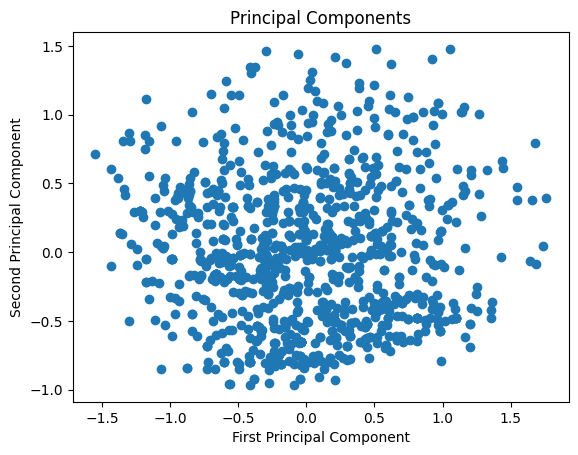

In [17]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_training)
pca_result_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
display(pca_result_df)

plt.scatter(x=pca_result_df["PC1"].values, y=pca_result_df["PC2"].values)
plt.title('Principal Components')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.savefig(f"needs_2d_visualization.png", format="png", dpi=300)
plt.show()

# 主成分考察

In [ ]:
# 主成分1

print('PC1の固有ベクトル\n', pca.components_[0])

# PC1に基づいてトップ10とボトム10のインデックスを取得
pc1_top_10_indices = pca_result_df.nlargest(10, 'PC1').index
pc2_bottom_10_indices = pca_result_df.nsmallest(10, 'PC1').index

# 元のベクトルを抽出
pc1_top_10_original_vectors = data_training.iloc[pc1_top_10_indices]
pc2_bottom_10_original_vectors = data_training.iloc[pc2_bottom_10_indices]

# 元のベクトルを表示
print("top10:" )
display(pc1_top_10_original_vectors)
print("bottom10: ")
display(pc2_bottom_10_original_vectors)

PC1の固有ベクトル
 [-0.15049394 -0.36946269 -0.11202948 -0.15799141 -0.49071821 -0.25390201
 -0.28065201 -0.24121207 -0.11300577 -0.10562772 -0.17867588  0.1231333
 -0.00148637 -0.31861813 -0.36215479  0.0070824  -0.18521648 -0.15189497]
top10:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
2,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0
109,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0
703,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0
946,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0
202,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0
284,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0
503,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0
860,0,0,1,1,0,0,0,0,0,1,0,1,1,0,0,1,0,0
46,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0
803,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0


bottom10: 


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
169,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
845,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1
233,1,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1
647,1,1,1,1,1,1,1,1,0,1,0,0,1,1,1,1,1,1
76,1,1,1,1,1,1,1,1,0,1,1,0,1,1,1,1,0,1
452,1,1,1,1,1,1,1,1,0,1,1,0,1,1,1,1,0,1
245,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1
396,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,0
18,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,0
425,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,0,0


In [ ]:
# 主成分2
print('PC2の固有ベクトル\n', pca.components_[1])

# PC2に基づいてトップ10とボトム10のインデックスを取得
pc2_top_10_indices = pca_result_df.nlargest(10, 'PC2').index
pc2_bottom_10_indices = pca_result_df.nsmallest(10, 'PC2').index

# 元のベクトルを抽出
pc2_top_10_original_vectors = data_training.iloc[pc2_top_10_indices]
pc2_bottom_10_original_vectors = data_training.iloc[pc2_bottom_10_indices]

# 元のベクトルを表示
print("top10")
display(pc2_top_10_original_vectors)
print("bottom10")
display(pc2_bottom_10_original_vectors)

PC2の固有ベクトル
 [ 0.002329907940268947   -0.1494865427313055      0.0363792177384905
 -0.06848782673657076    -0.1325133187797386      0.6376444273473912
  0.00027368836929280793  0.34757293022230074     0.1029684196181354
 -0.04107484336224411    -0.3968588251278407      0.46004134640129246
 -0.04698998838969434     0.11578749893968888    -0.029411956654792164
  0.003750639410060031    0.0037931785660436316  -0.169541071062793     ]
top10


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
476,1,0,0,0,0,1,0,1,1,1,0,1,1,0,0,1,0,0
5,1,0,1,1,0,1,1,1,1,1,0,1,1,0,0,1,0,0
23,1,0,1,1,0,1,1,1,0,1,0,1,1,1,1,1,0,0
13,1,0,1,1,1,1,1,1,1,1,0,1,1,1,0,1,0,0
496,0,0,1,0,0,1,1,1,0,1,0,1,1,0,0,1,0,0
137,1,0,1,1,1,1,0,1,0,0,0,1,1,1,0,1,0,0
407,1,1,1,0,0,1,1,1,1,1,0,1,1,0,0,1,0,0
878,1,0,1,1,0,1,1,1,0,1,0,1,1,0,0,1,0,0
914,0,0,1,1,1,1,1,1,0,1,0,1,0,1,1,1,0,0
964,1,0,1,1,1,1,1,1,0,1,0,1,1,1,0,1,1,0


bottom10


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
175,1,1,0,1,1,0,1,0,0,1,1,0,1,0,0,1,0,1
16,0,1,1,1,1,0,1,0,0,1,1,0,1,0,1,1,0,1
600,1,1,1,1,1,0,1,0,0,1,1,0,1,0,1,0,0,1
250,1,1,1,1,1,0,1,0,0,1,1,0,1,0,1,1,0,1
176,1,1,1,1,1,0,0,0,0,1,1,0,1,0,1,1,0,1
265,0,1,1,1,1,0,1,0,0,1,1,0,1,0,0,1,0,1
753,0,1,1,1,1,0,1,0,0,1,1,0,1,0,0,1,0,1
472,1,1,1,1,1,0,1,0,0,1,1,0,1,0,0,1,1,1
655,1,1,1,1,1,0,1,0,0,1,1,0,1,0,0,1,1,1
34,1,1,1,1,1,0,0,0,0,1,1,0,1,0,0,1,0,1


In [ ]:
def RSCCMM(X, C, delta):
  n, m = X.shape
  u = np.zeros((C,n))
  normalized_u = np.zeros((C,n))

  #要素の正規化
  #sys.float_info.epsilon を足してないと、類似度計算の時にlog(0)となってNaNが発生する
  # X = X + sys.float_info.epsilon
  # np.where(X == 0, sys.float_info.epsilon, X)
  normalized_X = X / np.sum(X, 1)[:, np.newaxis]

  #類似度
  s_it = np.array([np.sum(normalized_X * np.log(row + sys.float_info.epsilon), 1) for row in normalized_X])

  #二項関係
  #deltaの値が小さすぎると二項関係がなくなって、(※)式のところでゼロ徐算が発生する
  R = (s_it >= delta).astype(np.float64)

  #初期項目メンバシップ
  w = np.array([X[c] + sys.float_info.epsilon for c in random.sample(range(n), C)])
  w /= w.sum(1)[:,np.newaxis]

  #繰り返し処理
  for i in range(100):
    old_u = normalized_u.copy()
    u = np.zeros((C,n))
    normalized_u = np.zeros((C,n))

    #HCCMM的なクラスター割り当てによるメンバシップ
    s = np.log(w) @ X.T
    s_max = np.max(s, 0)
    u = (s >= s_max).astype(np.float64)

    #粒状性（二項関係）を考慮した上近似メンバシップ
    if(np.any(np.sum(R, 1) == 0)):
       raise Exception("二項関係がない")
    normalized_u = ((u @ R.T) / np.sum(R, 1) > 0).astype(np.float64) #(※)
    normalized_u /= normalized_u.sum(0)

    #正規化メンバシップ更新
    #ここでも微小値を足していないと次の類似度計算の時にNaNになって計算できなくなる
    w = (normalized_u @ X) + sys.float_info.epsilon
    if(np.any(np.isnan(w.sum(1)))):
      raise Exception("NaN発生")
    w /= w.sum(1)[:, np.newaxis]

    if np.abs(normalized_u - old_u).max() == 0:
      break

  return normalized_u.T @ w, (u @ R.T) / np.sum(R, 1)

In [ ]:
#roopの回数を指定し、最大のaucとその時のクラスター構造を返す関数(RSCCMM)
def RSCCMM_CF_AUC_CLUSTER(roop, test, X, C, delta):
  n, m = X.shape
  test_num, test_num_fact = test.shape
  auc_max = 0
  rm_max = 0

  test_true = np.zeros(test_num)
  r_test_score = np.zeros(test_num)

  for i in range(test_num):
    test_true[i] = test[i][2]

  for i in range(roop):
    r, rm = RSCCMM(X, C, delta) # RSCCM法を適用

    for j in range(test_num):
      r_test_score[j] = r[test[j][0]][test[j][1]]

    auc = roc_auc_score(test_true, r_test_score) # AUCを計算

    if auc > auc_max:
      auc_max = auc
      rm_max = rm


  return auc_max, rm_max

auc, rm = RSCCMM_CF_AUC_CLUSTER(10, test_needs, X_needs, 3, -7)
print("auc: ", auc)

auc:  0.8471700777460296


auc_max:  0.8533332779586683
delta_max:  -5.0


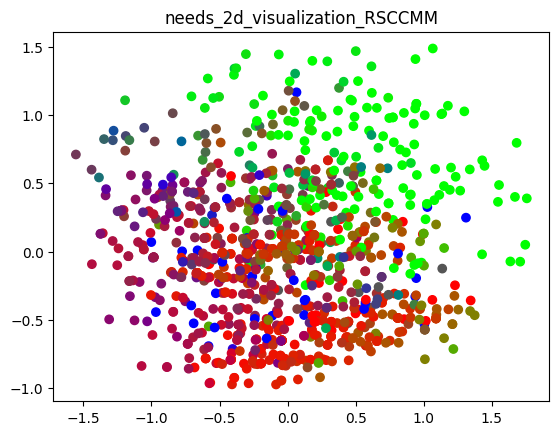

In [ ]:
name = "needs_2d_visualization_RSCCMM"
C = 3
loop = 10
delta_list = np.arange(-5, -9, -0.5)

auc_max = 0
rm_max = 0
delta_max = 0
for delta in delta_list:
  auc, rm = RSCCMM_CF_AUC_CLUSTER(10, test_needs, X_needs, C, delta)
  if auc > auc_max:
    auc_max = auc
    rm_max = rm
    delta_max = delta


print("auc_max: ", auc_max)
print("delta_max: ", delta_max)

plt.scatter(x='PC1', y='PC2', data=pca_result_df, color=rm_max.T)
plt.title(name)
plt.rcParams["font.size"] = 11
plt.savefig(f"{name}.png", format="png", dpi=300)

with open(f'{name}_rough_membership.csv', 'wt', encoding='utf-8', newline='') as fout:
    writer = csv.writer(fout)
    writer.writerows(rm_max)

output_info = [["auc", "delta"]]
output_info.append([auc_max, delta_max])
with open(f'{name}_info.csv', 'wt', encoding='utf-8', newline='') as fout:
    writer = csv.writer(fout)
    writer.writerows(output_info)

[[0.77777778 0.92424242 0.         ... 0.46875    0.81269841 0.36111111]
 [0.         0.01515152 0.         ... 0.03125    0.11428571 0.38888889]
 [0.22222222 0.06060606 1.         ... 0.5        0.07301587 0.25      ]]


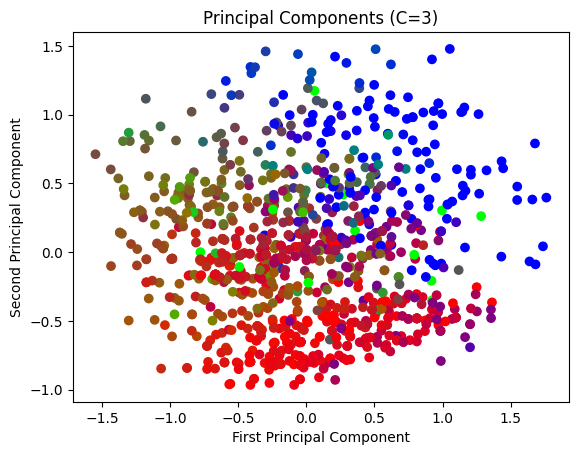

In [18]:
# csvデータから再現
name = "needs_2d_visualization_RSCCMM"
input = pd.read_csv(f'{name}_rough_membership.csv', header=None)

print(input.values)

plt.scatter(x='PC1', y='PC2', data=pca_result_df, color=input.values.T)
plt.title('Principal Components (C=3)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.rcParams["font.size"] = 11
plt.savefig(f"{name}.png", format="png", dpi=300)